# Transformer

## Embedding

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# expected input shape: (batch_size, seq_length, input_dim)
# format: norm, linear, + position_emb, norm, dropout
import math
class Embedding(nn.Module):
  def __init__(self, d_input, d_model, bias=True):
    super(Embedding, self).__init__()
    self.d_input = d_input
    self.d_model = d_model
    self.bias = bias

    self.linear = nn.Linear(d_input, d_model, bias)
    # self.token_type_embedding = nn.Embedding(num_embeddings=2, embedding_dim= d_model)

    self.norm1 = nn.LayerNorm(d_input)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(p=0.1)
    self.pe = self.positional_encoding(200)
    self.pe.requires_grad = False


  def positional_encoding(self, max_len):
    pe = torch.zeros(max_len, self.d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)
    return pe


  def forward(self, axes):
    input = self.norm1(axes)
    linear_embeddings = self.linear(input)

    pe_batched = self.pe[:linear_embeddings.size(1), :]
    pe_batched = pe_batched.view(linear_embeddings.size(1), -1)
    pe_batched = pe_batched.repeat(linear_embeddings.size(0), 1, 1)

    #req_grad is False for static pos_embedding
    embeddings = linear_embeddings
    embeddings = embeddings + pe_batched.requires_grad_(False)
    embeddings = self.norm2(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings

## Multi-head attention

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9).clone()
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, self.h, 1, 1)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)


## Encoder

In [ ]:
import torch.nn.functional as F

In [ ]:
# expected input shape: (batch_size, seq_length, model_dim)
class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, ff_hidden_dim, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.linear1 = nn.Linear(d_model, ff_hidden_dim)
        self.linear2 = nn.Linear(ff_hidden_dim, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src2 = self.self_attn(src, src, src, mask=src_mask)
        src = src + self.dropout(src2)  # not an in-place operation
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout(src2)  # not an in-place operation
        src = self.norm2(src)
        return src


class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, h, ff_hidden_dim, dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, h, ff_hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, src, mask=None):
        for layer in self.layers:
            src = layer(src, mask)
        return src


## Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, ff_hidden_dim, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.cross_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.linear1 = nn.Linear(d_model, ff_hidden_dim)
        self.linear2 = nn.Linear(ff_hidden_dim, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, src, src_mask=None, tgt_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, mask=tgt_mask)
        tgt = tgt + self.dropout(tgt2)  # not an in-place operation
        tgt = self.norm1(tgt)

        tgt2 = self.cross_attn(tgt, src, src, mask=src_mask)
        tgt = tgt + self.dropout(tgt2)  # not an in-place operation
        tgt = self.norm2(tgt)

        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout(tgt2)  # not an in-place operation
        tgt = self.norm3(tgt)

        return tgt


class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, h, ff_hidden_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, h, ff_hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, tgt, memory, src_mask=None, tgt_mask=None):

        for layer in self.layers:
            tgt = layer(tgt, memory, src_mask=src_mask, tgt_mask=tgt_mask)
        return tgt

## Projection

In [ ]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, d_output) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, d_output)

    def forward(self, x) -> None:
        # feed it last decoder output for prediction
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

## Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as dist

class GaussianSample(nn.Module):
    def __init__(self, input_dim, output_dim=3):
        super(GaussianSample, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Transform input tensor
        transformed = self.linear(F.relu(x))  # Shape: (batch_size, seq_len, 3)

        # Extract parameters
        mean1 = transformed[..., 0]  # Shape: (batch_size, seq_len)
        mean2 = transformed[..., 1]  # Shape: (batch_size, seq_len)
        log_var = transformed[..., 2]  # Shape: (batch_size, seq_len)

        # Variance must be positive, so we use an exponential function
        var = torch.exp(log_var)  # Shape: (batch_size, seq_len)

        # Create Gaussian distributions
        dist1 = dist.Normal(mean1, torch.sqrt(var))
        dist2 = dist.Normal(mean2, torch.sqrt(var))

        # Sample from the distributions
        sample1 = dist1.rsample()  # Shape: (batch_size, seq_len)
        sample2 = dist2.rsample()  # Shape: (batch_size, seq_len)

        # Stack samples to get the final output shape (batch_size, seq_len, 2)
        samples = torch.stack([sample1, sample2], dim=-1)  # Shape: (batch_size, seq_len, 2)

        return samples

# Example
batch_size = 5
hidden_size = 10
input_tensor = torch.randn(batch_size, 13, hidden_size)

# Create the model and forward the input tensor
model = GaussianSample(hidden_size)
samples = model(input_tensor)

In [ ]:
class Transformer(nn.Module):
  def __init__(self, d_input, d_model, num_layers, h, ff_hidden_dim, dropout):
    super(Transformer, self).__init__()
    self.embedding =  Embedding(d_input, d_model)
    self.encoder = Encoder(num_layers, d_model, h, ff_hidden_dim, dropout)
    self.decoder = Decoder(num_layers, d_model, h, ff_hidden_dim, dropout)
    #self.project = nn.Linear(d_model, d_input)
    self.sampler = GaussianSample(d_model)

  def forward(self, src, tgt, src_mask=None, tgt_src_mask=None, tgt_mask=None, inference= False):
    src = self.embedding(src)
    tgt = self.embedding(tgt)
    encoder_out = self.encoder(src, src_mask)
    decoder_out = self.decoder(tgt, encoder_out, src_mask= tgt_src_mask, tgt_mask= tgt_mask)
    if inference == True:
      sampler_out = self.sampler(decoder_out[:, -1])
    else:
      sampler_out = self.sampler(decoder_out)

    return sampler_out
    '''
    if inference == True:
      project_out = self.project(decoder_out[:, -1])
    else:
      project_out = self.project(decoder_out)

    return project_out
    '''

# Sample data preprocess

Approach:
* calculating angles of change and scale of change for each consecutive trajectory points.
* scaling the scales to make loss not very small
* calculating loss for each one ans then their weighted sum

* version 1: not including the coordinates_only starting point (would probably work for short paths but not long ones, append coordinate of last input point, should define a separate embedding for it)
* version 2: including the coordinates (similart but instead of only end, for every m mins)

* have to define new sequences with shorter paths for train and test

In [ ]:
def prepaire_batch(batch_idx, max_len_input, mex_len_pred): # here we have the data in matrix for and want to iterate over it by batches of indexees
    # concat x,y axes for input and pred
    axes           = torch.stack((train_tensors_dict['latitude']['input'][batch_idx],
                                train_tensors_dict['longitude']['input'][batch_idx])
                                , dim=2)

In [ ]:
coords = torch.stack((train_tensors_dict['latitude']['input'][[1]],
                                train_tensors_dict['longitude']['input'][[1]])
                                , dim=2)
coords = np.array(coords)[0][:30]
coords.shape

(30, 2)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Sample data: a list of coordinates (latitude, longitude)


# Function to compute angle and scale of change between consecutive points
def compute_angle_and_scale(coords, scale_factor=1e3):
    deltas = np.diff(coords, axis=0)
    scales = np.linalg.norm(deltas, axis=1) * scale_factor  # scale up
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])  # calculate angle in radians
    return scales, angles

# Generate angle and scale features from coordinates
scales, angles = compute_angle_and_scale(coords)
print('scales: ', scales)
print('angles: ', angles)
starting_point = coords[0]
print(starting_point)


# Prepare input features: replicate starting_point and append scales, angles as columns
num_points = len(scales)
starting_points = np.tile(starting_point, (num_points, 1))  # repeat starting point for each step
input_features = np.column_stack([starting_points, scales, angles])
print('input features: ', input_features)

'''
# Sample Model (Transformer) setup
class TrajectoryModel(nn.Module):
    def __init__(self, d_model=128, num_layers=4, num_heads=4, dim_ff=512, dropout=0.1):
        super(TrajectoryModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_ff, dropout=dropout)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 2)  # Predicts latitude and longitude deltas

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, features)
        x = self.encoder(x)
        return self.fc(x[-1])  # Final position prediction (latitude, longitude)

# Define a custom loss function to balance MSE on relative movement and final target
class CustomTrajectoryLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(CustomTrajectoryLoss, self).__init__()
        self.alpha = alpha  # weight for final position vs relative changes

    def forward(self, pred_deltas, true_deltas, pred_final, true_final):
        # MSE for relative changes (angles and scales)
        loss_relative = nn.MSELoss()(pred_deltas, true_deltas)
        # MSE for final position
        loss_final = nn.MSELoss()(pred_final, true_final)
        return self.alpha * loss_relative + (1 - self.alpha) * loss_final

# Prepare data for model (sample tensor, would come from preprocessed data)
input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # batch size of 1
target_deltas = torch.tensor(np.diff(coords, axis=0), dtype=torch.float32).unsqueeze(0)
target_final = torch.tensor(coords[-1], dtype=torch.float32).unsqueeze(0)

# Model, loss, and optimizer setup
model = TrajectoryModel()
criterion = CustomTrajectoryLoss(alpha=0.7)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training step example
model.train()
optimizer.zero_grad()
pred_deltas = model(input_tensor)  # Predictions (replace with proper sequence if needed)
loss = criterion(pred_deltas, target_deltas, pred_deltas[-1], target_final)
loss.backward()
optimizer.step()

print(f"Training Loss: {loss.item()}")
'''

scales:  [2.2239392e+00 9.6963120e-01 4.0787802e+00 1.4191955e+00 3.4129670e+00
 1.9361534e+00 2.8939652e+00 4.5405107e+00 7.1089911e+00 8.8380470e+00
 1.1586313e+01 1.3738498e+01 1.3939623e+01 1.3823541e+01 1.3730998e+01
 1.3490179e+01 1.3969980e+01 1.4772376e+01 1.4450988e+01 1.3658280e+01
 1.3506229e+01 1.3868841e+01 1.0977753e+01 2.9444423e+00 1.4051348e+00
 2.4425982e-02 1.1444092e-02 0.0000000e+00 2.5481949e+00]
angles:  [ 2.965728    2.9032934   2.941996    2.946833    2.9481428   2.9472883
  2.9317882   2.9522707   2.2344751   2.233808    2.9487815  -2.865429
  2.8876536   2.79235     2.7857485   2.9162986   2.9897323  -2.4652386
 -2.4554732   3.0346982   2.9014776   2.7540376   1.4729948   0.22738148
 -1.6142472   2.4668517   0.          0.         -2.3180773 ]
[  37.79795 -122.42219]
input features:  [[ 3.7797951e+01 -1.2242219e+02  2.2239392e+00  2.9657280e+00]
 [ 3.7797951e+01 -1.2242219e+02  9.6963120e-01  2.9032934e+00]
 [ 3.7797951e+01 -1.2242219e+02  4.0787802e+00  2.94

'\n# Sample Model (Transformer) setup\nclass TrajectoryModel(nn.Module):\n    def __init__(self, d_model=128, num_layers=4, num_heads=4, dim_ff=512, dropout=0.1):\n        super(TrajectoryModel, self).__init__()\n        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_ff, dropout=dropout)\n        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)\n        self.fc = nn.Linear(d_model, 2)  # Predicts latitude and longitude deltas\n\n    def forward(self, x):\n        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, features)\n        x = self.encoder(x)\n        return self.fc(x[-1])  # Final position prediction (latitude, longitude)\n\n# Define a custom loss function to balance MSE on relative movement and final target\nclass CustomTrajectoryLoss(nn.Module):\n    def __init__(self, alpha=0.7):\n        super(CustomTrajectoryLoss, self).__init__()\n        self.alpha = alpha  # weight for fi

In [ ]:
scales[3]

7.07106781159778

# Train

## prepaire batch (Cabspotting)

In [ ]:
def prepaire_batch(batch_idx, max_len_input, mex_len_pred): # here we have the data in matrix for and want to iterate over it by batches of indexees
    # concat x,y axes for input and pred
    axes           = torch.stack((train_tensors_dict['latitude']['input'][batch_idx],
                                train_tensors_dict['longitude']['input'][batch_idx])
                                , dim=2)

    # token_type_ids = train_tensors_dict['occupancy']['input'][i['idx']]  commented cuz don't wanna consider occupancy in this case

    axes_pred      = torch.stack((train_tensors_dict['latitude']['pred'][batch_idx],
                                  train_tensors_dict['longitude']['pred'][batch_idx])
                                  , dim=2)

    # create attention masks for src, tgt and tgt_src
    seq_lens              = [len(train_data[batch_idx[i].item()]['time']) for i in range(len(batch_idx))] # we can use other cols (e.g. latitude) too, it's kinda just to know the len of seq
    seq_lens_input        = [seq_len - seq_len//5 for seq_len in seq_lens]
    seq_lens_pred         = [          seq_len//5 for seq_len in seq_lens]


    attention_masks_input = [torch.tensor([1 for _ in range(seq_len)]
                                           + [0]*(max_len_input - seq_len))
                            for seq_len in seq_lens_input]
    attention_masks_pred = [torch.tensor([1 for _ in range(seq_len-1)]
                                           + [0]*(mex_len_pred - seq_len)).view(-1, 1).repeat(1, 2)
                            for seq_len in seq_lens_pred]


    src_mask  = [torch.ger(attention_mask, attention_mask) for attention_mask in attention_masks_input]
    #pred_mask = [torch.ger(attention_mask, attention_mask) for attention_mask in attention_masks_pred]
    src_mask  = torch.stack(src_mask)
    #pred_mask = torch.stack(pred_mask)
    pred_mask = torch.triu(torch.ones((axes.shape[0], mex_len_pred-1, mex_len_pred-1)), diagonal=1).type(torch.int)
    pred_mask = (pred_mask+1)%2

    loss_mask = [attention_mask for attention_mask in attention_masks_pred]
    loss_mask = torch.stack(loss_mask)

    pred_src_mask = [attention_mask.repeat(mex_len_pred-1,1) for attention_mask in attention_masks_input]
    pred_src_mask = torch.stack(pred_src_mask)

    output = dict()
    output['axes'] = dict()
    output['axes']['input'] = axes
    output['axes']['pred']  = axes_pred
    output['mask'] = dict()
    output['mask']['src'] = src_mask
    output['mask']['tgt'] = pred_mask
    output['mask']['tgt_src'] = pred_src_mask
    output['mask']['loss'] = loss_mask

    return output

In [ ]:
train_data[0]['latitude'][:5]

[37.75153, 37.75149, 37.75149, 37.75149, 37.75144]

In [ ]:
def prepaire_batch_test(batch_idx, max_len_input, mex_len_pred): # here we have the data in matrix for and want to iterate over it by batches of indexees
    # concat x,y axes for input and pred
    axes           = torch.stack((test_tensors_dict['latitude']['input'][batch_idx],
                                test_tensors_dict['longitude']['input'][batch_idx])
                                , dim=2)

    # token_type_ids = test_tensors_dict['occupancy']['input'][i['idx']]  commented cuz don't wanna consider occupancy in this case

    axes_pred      = torch.stack((test_tensors_dict['latitude']['pred'][batch_idx],
                                  test_tensors_dict['longitude']['pred'][batch_idx])
                                  , dim=2)

    # create attention masks for src, tgt and tgt_src
    seq_lens              = [len(test_data[batch_idx[i].item()]['time']) for i in range(len(batch_idx))] # we can use other cols (e.g. latitude) too, it's kinda just to know the len of seq
    seq_lens_input        = [seq_len - seq_len//5 for seq_len in seq_lens]
    seq_lens_pred         = [          seq_len//5 for seq_len in seq_lens]


    attention_masks_input = [torch.tensor([1 for _ in range(seq_len)]
                                           + [0]*(max_len_input - seq_len))
                            for seq_len in seq_lens_input]
    attention_masks_pred = [torch.tensor([1 for _ in range(seq_len-1)]
                                           + [0]*(mex_len_pred - seq_len)).view(-1, 1).repeat(1, 2)
                            for seq_len in seq_lens_pred]


    src_mask  = [torch.ger(attention_mask, attention_mask) for attention_mask in attention_masks_input]
    #pred_mask = [torch.ger(attention_mask, attention_mask) for attention_mask in attention_masks_pred]
    src_mask  = torch.stack(src_mask)
    #pred_mask = torch.stack(pred_mask)
    pred_mask = torch.triu(torch.ones((axes.shape[0], mex_len_pred-1, mex_len_pred-1)), diagonal=1).type(torch.int)
    pred_mask = (pred_mask+1)%2

    loss_mask = [attention_mask for attention_mask in attention_masks_pred]
    loss_mask = torch.stack(loss_mask)

    pred_src_mask = [attention_mask.repeat(mex_len_pred-1,1) for attention_mask in attention_masks_input]
    pred_src_mask = torch.stack(pred_src_mask)

    output = dict()
    output['axes'] = dict()
    output['axes']['input'] = axes
    output['axes']['pred']  = axes_pred
    output['mask'] = dict()
    output['mask']['src'] = src_mask
    output['mask']['tgt'] = pred_mask
    output['mask']['tgt_src'] = pred_src_mask
    output['mask']['loss'] = loss_mask

    return output

In [ ]:
for i in test_idx_loader:
  batch_idx = i['idx']
  output = prepaire_batch(batch_idx, max_len_input=120, mex_len_pred=30)
  break

NameError: name 'test_idx_loader' is not defined

In [ ]:
'''
train_data
test_tensors_dict
train_idx
train_idx_loader


for i in valid_idx_loader:
  print(test_tensors_dict['time']['input'][i['idx']].shape)


axes = torch.stack((train_tensors_dict['latitude']['input'][i['idx']],
                    train_tensors_dict['longitude']['input'][i['idx']])
                    , dim=2)
'''

## train loop

In [ ]:
# define hyper parameters
# validation loop and use it for training
# lr scheduler?

In [ ]:
import tqdm
from tqdm import tqdm

In [ ]:
# parameters

import torch.optim as optim

d_input = 2
d_model = 32
num_layers = 6
h = 8
ff_hidden_dim = 64
dropout = 0.1

model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
#Encoder(num_layers, d_model, h, ff_hidden_dim, dropout)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
num_epochs = 5

def train_loop():
  for epoch_num in range(num_epochs):
    epoch_loss = 0
    model.train()

    for idx in tqdm(train_idx_loader):
      batch_idx = idx['idx']

      batch = prepaire_batch(batch_idx, max_len_input=120, mex_len_pred=30)

      input_axes = batch['axes']['input']
      pred_axes  = batch['axes']['pred']
      src_mask   = batch['mask']['src']
      tgt_mask   = batch['mask']['tgt']
      tgt_src_mask = batch['mask']['tgt_src']
      loss_mask  = batch['mask']['loss']

      tgt_axes = pred_axes[:, :-1]
      real_axes = pred_axes[:, 1:]


      out = model(input_axes, tgt_axes, src_mask, tgt_src_mask, tgt_mask, inference=False)
      out = out.masked_fill(loss_mask == 0, 0)

      y =   real_axes
      loss = criterion(out, y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    test_loop(loaded_model, test_idx_loader, max_len_pred=29)

    train_loss = epoch_loss / len(train_idx_loader)

    print(f'Loss of epoch {epoch_num} is: ', train_loss)

    torch.save(model.state_dict(), '/content/drive/My Drive/models/TT.pt')

train_loop()

100%|██████████| 1021/1021 [27:42<00:00,  1.63s/it]


Loss of epoch 0 is:  7490.610846539085


  4%|▍         | 45/1021 [01:13<26:35,  1.63s/it]


KeyboardInterrupt: 

## load the model

In [ ]:
d_input = 2
d_model = 256
num_layers = 4
h = 4
ff_hidden_dim = 512
dropout = 0.1


criterion = torch.nn.MSELoss()
loaded_model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/models/TT.pt'))

<ipython-input-29-af7a1b799cef>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/My Drive/models/TT.pt'))


<All keys matched successfully>

## test loop

In [ ]:
import tqdm
from tqdm import tqdm

In [ ]:
def test_loop(model, idx_loader, max_len_pred):
    model.eval()
    total_test_loss = 0
    batch_num = 0

    for idx in tqdm(idx_loader):
      batch_idx = idx['idx']
      with torch.no_grad():
        # calculate the sum original lenghts of the sequences for calculating the true loss
        output = prepaire_batch_test(batch_idx, max_len_input=120, mex_len_pred=30)
        input_axes = output['axes']['input']
        pred_axes  = output['axes']['pred']
        src_mask   = output['mask']['src']
        tgt_mask   = output['mask']['tgt']
        tgt_src_mask = output['mask']['tgt_src']
        loss_mask  = output['mask']['loss']


        try:
          tgt_axes = pred_axes[:, 0].clone()

          tgt_axes = tgt_axes.view(64,1,2)
          real_axes = pred_axes[:, 1:].clone()
          batch_num+= 1
          for i in range(max_len_pred):
                tgt_src_mask_ = tgt_src_mask[:, :i+1]
                out = model(input_axes, tgt_axes, src_mask, tgt_src_mask_, tgt_mask=None, inference=True)
                out = out.masked_fill(loss_mask[:, i] == 0, 0).clone()

                y = real_axes[:, i]
                loss = criterion(out, y)
                total_test_loss += loss.item()
                out = out.view(64,1,2)
                tgt_axes = torch.cat((tgt_axes, out), dim=1)
          return (real_axes, tgt_axes)
        except:
          pass


    avg_test_loss = total_test_loss / (batch_num*max_len_pred)
    print(f"Test Loss: {avg_test_loss}")
    return avg_test_loss

In [ ]:
real, pred = test_loop(loaded_model, test_idx_loader, max_len_pred=29)

In [ ]:
pred = pred[:, 1:]
pred.size() == real.size()

True

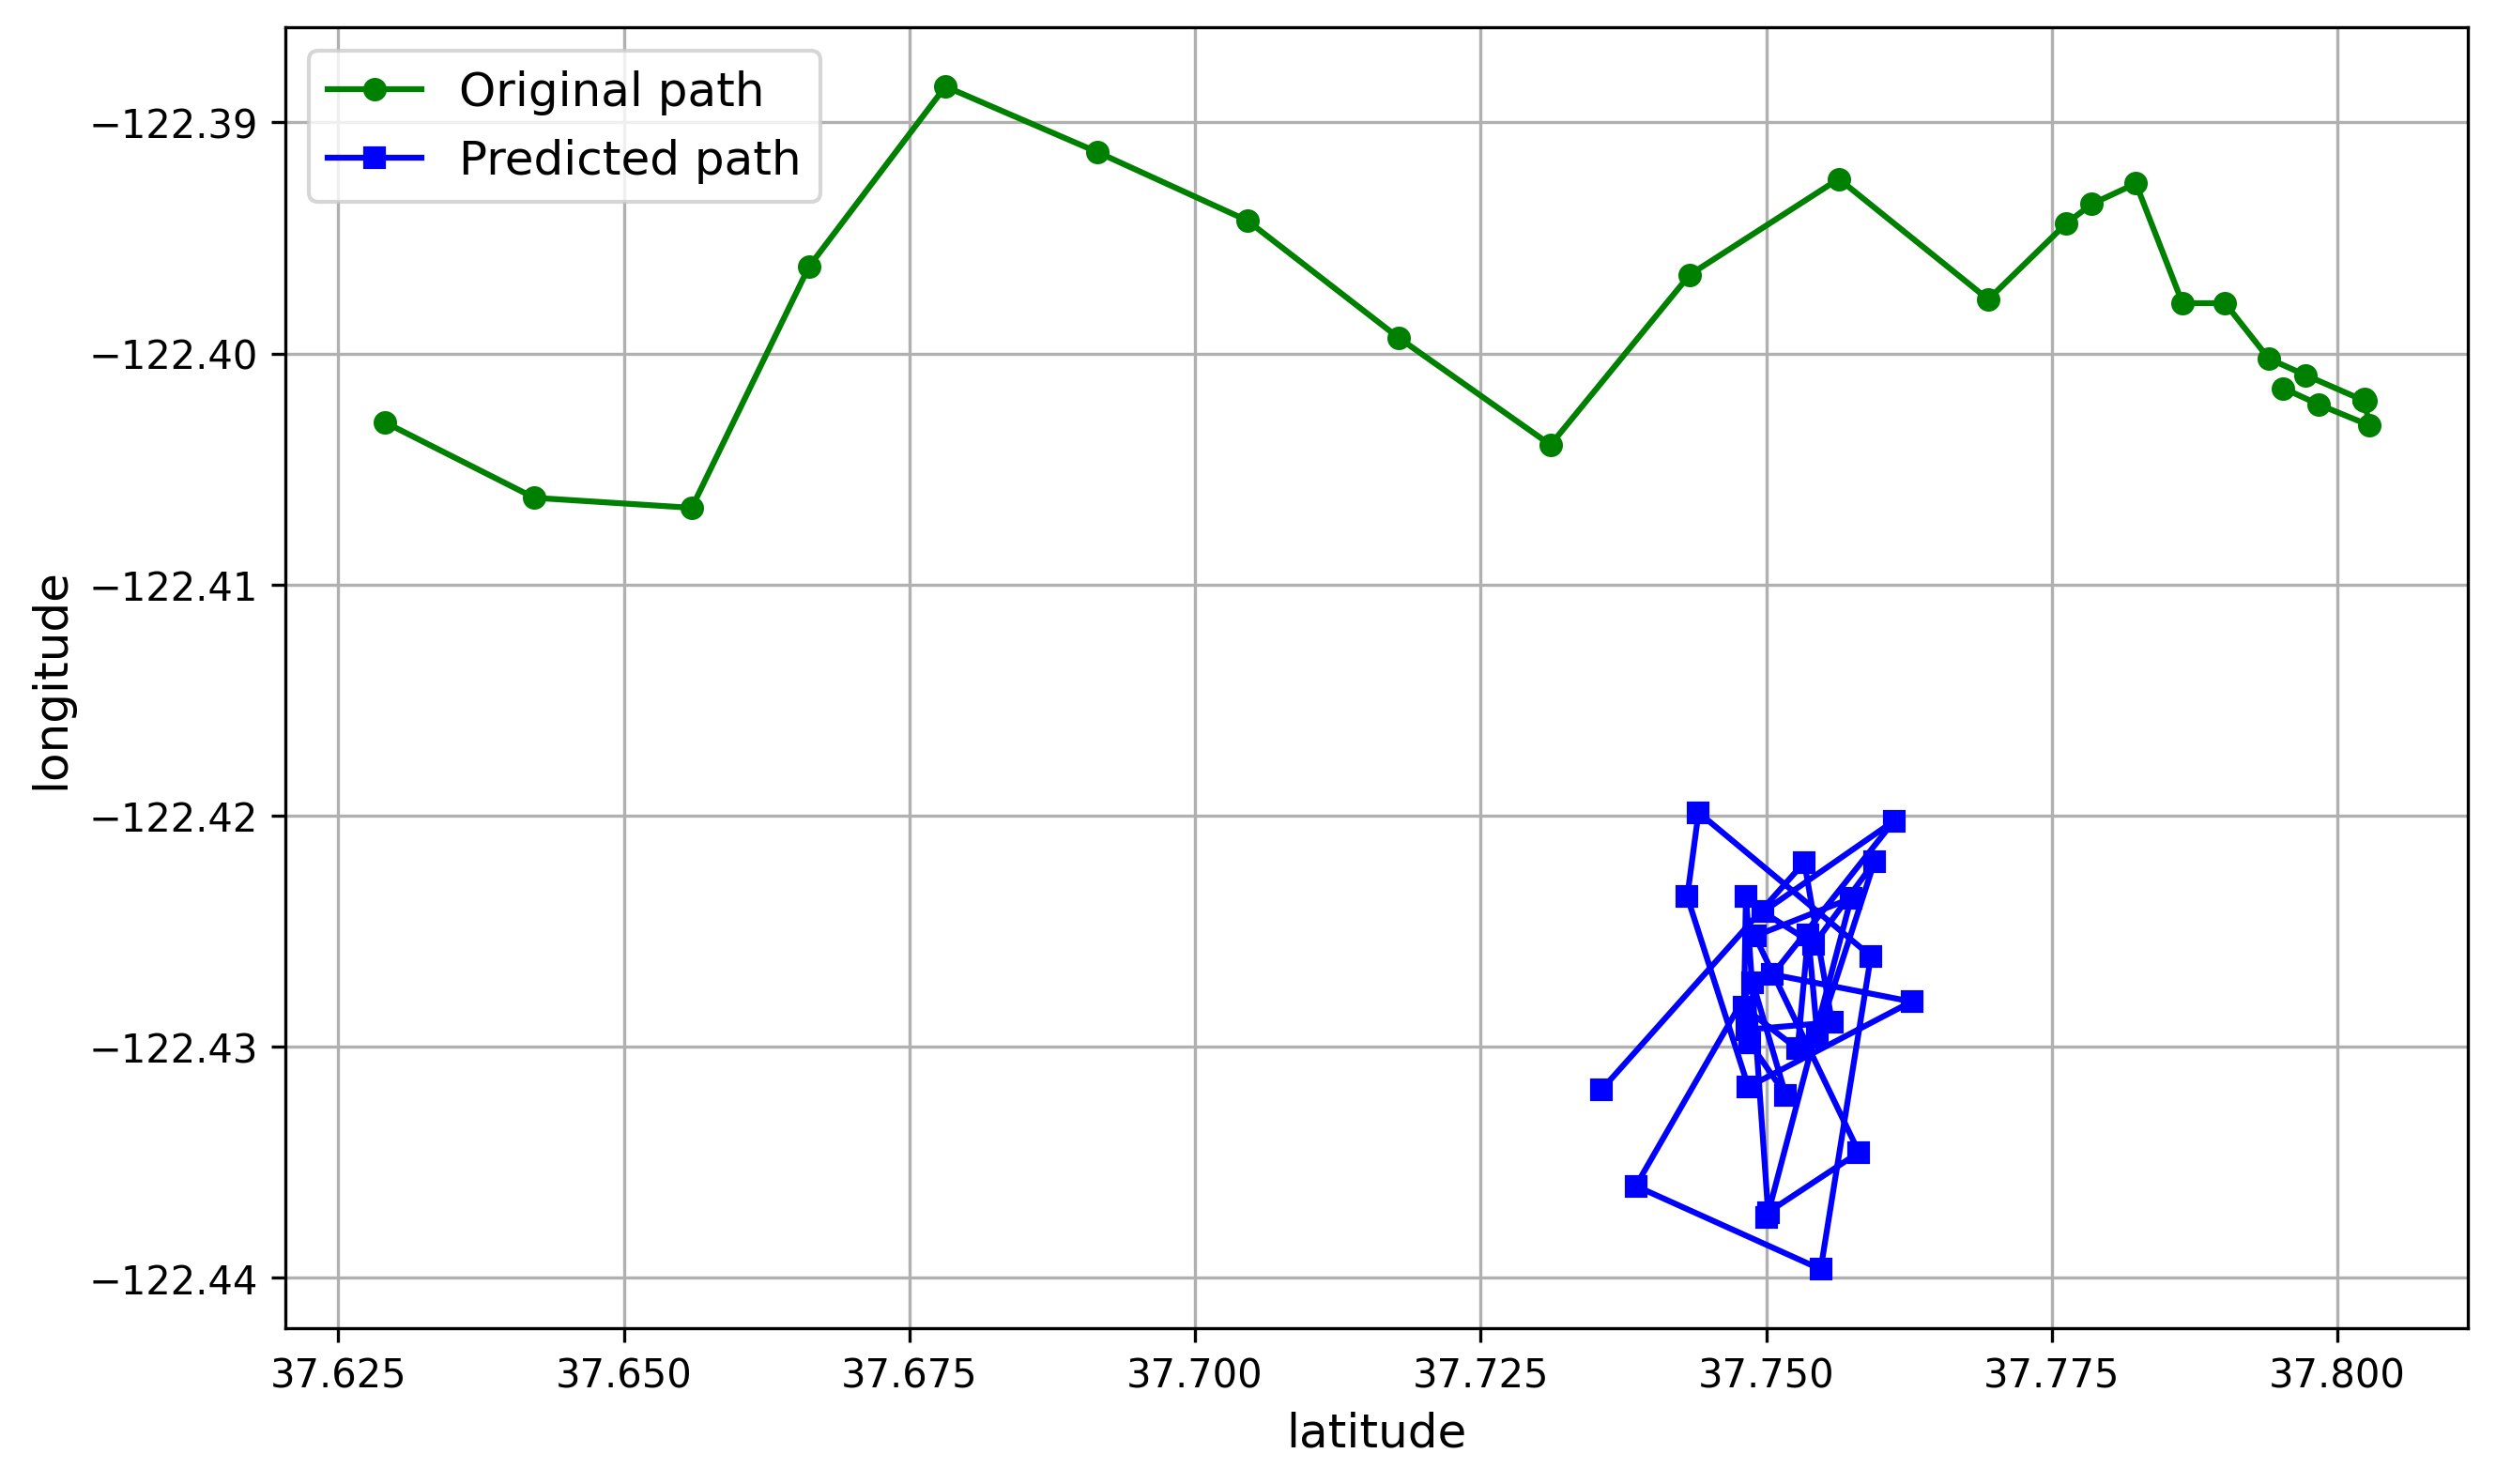

In [ ]:
# Plot the real and predicted paths
import matplotlib.pyplot as plt


# Convert to numpy for easy slicing
import numpy as np
real_ = np.array(real[0])
pred_ = np.array(pred[0])

# Plot the paths
plt.figure(figsize=(10, 6), dpi=300)  # High resolution for paper

# Path 1
plt.plot(real_[:, 0], real_[:, 1], 'o-', label="Original path", color='green', markersize=5, linewidth=1.5)

# Path 2
plt.plot(pred_[:, 0], pred_[:, 1], 's-', label="Predicted path", color='blue', markersize=5, linewidth=1.5)

# Add title and labels
plt.xlabel('latitude', fontsize=12)
plt.ylabel('longitude', fontsize=12)

# Add grid
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Save the figure as a high-resolution image (suitable for publication)
plt.savefig('path_comparison_plot.png', bbox_inches='tight')

# Show plot
plt.show()


In [ ]:
test_loop(loaded_model, test_idx_loader, max_len_pred=29)

 20%|██        | 11/55 [02:31<07:20, 10.01s/it]

In [ ]:
 def custom_prepaire_batch_test(batch_idx, len_input, len_pred): # here we have the data in matrix for and want to iterate over it by batches of indexees
    # concat x,y axes for input and pred
    axes           = torch.stack((test_tensors_dict['latitude']['input'][batch_idx],
                                test_tensors_dict['longitude']['input'][batch_idx])
                                , dim=2)
    axes           = axes[:, :len_input-1,:]

    # token_type_ids = test_tensors_dict['occupancy']['input'][i['idx']]  commented cuz don't wanna consider occupancy in this case

    axes_pred      = torch.stack((test_tensors_dict['latitude']['input'][batch_idx],
                                  test_tensors_dict['longitude']['input'][batch_idx])
                                  , dim=2)
    axes_pred      = axes_pred[:, len_input-1:(len_input-1)+len_pred+1, :]

    # create attention masks for src, tgt and tgt_src
    seq_lens_input        = [len_input-1 for i in range(64)]
    seq_lens_pred         = [len_pred+1  for i in range(64)] # batch_size=64


    #pred_mask = torch.stack(pred_mask)
    pred_mask = torch.triu(torch.ones((axes.shape[0], len_pred, len_pred)), diagonal=1).type(torch.int)
    pred_mask = (pred_mask+1)%2


    output = dict()
    output['axes'] = dict()
    output['axes']['input'] = axes
    output['axes']['pred']  = axes_pred
    output['mask'] = dict()
    output['mask']['tgt'] = pred_mask

    return output

In [ ]:
def custom_test_loop(model, idx_loader, len_input, len_pred):
    model.eval()
    total_test_loss = 0
    batch_num = 0

    for idx in tqdm(idx_loader):
      batch_idx = idx['idx']
      with torch.no_grad():
        # calculate the sum original lenghts of the sequences for calculating the true loss
        output = custom_prepaire_batch_test(batch_idx, len_input, len_pred)
        input_axes = output['axes']['input']
        pred_axes  = output['axes']['pred']
        tgt_mask   = output['mask']['tgt']


        try:
          tgt_axes = pred_axes[:, 0].clone()

          tgt_axes = tgt_axes.view(64,1,2)

          real_axes = pred_axes[:, 1:].clone()

          batch_num+= 1
          for i in range(len_pred):
                tgt_src_mask_ = tgt_src_mask[:, :i+1]
                out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=None, inference=True)

                y = real_axes[:, i]
                loss = criterion(out, y)
                total_test_loss += loss.item()
                out = out.view(64,1,2)
                tgt_axes = torch.cat((tgt_axes, out), dim=1)
        except:
          pass
    avg_test_loss = total_test_loss / (batch_num*len_pred)
    return avg_test_loss

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=35, len_pred=10)

100%|██████████| 55/55 [02:33<00:00,  2.80s/it]


0.0019590945824920374

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=40, len_pred=10)

100%|██████████| 55/55 [02:57<00:00,  3.24s/it]


0.001980215558325182

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=10, len_pred=10)

100%|██████████| 55/55 [01:02<00:00,  1.13s/it]


0.0020548217033070546

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input =70, len_pred=20)

100%|██████████| 55/55 [10:57<00:00, 11.96s/it]


35.9780679434518

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=60, len_pred=20)

100%|██████████| 55/55 [09:29<00:00, 10.35s/it]


0.001966830335947668

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=40, len_pred=20)

100%|██████████| 55/55 [06:34<00:00,  7.16s/it]


0.002004748262212767

In [ ]:
custom_test_loop(loaded_model, test_idx_loader, len_input=80, len_pred=20)

100%|██████████| 55/55 [12:35<00:00, 13.74s/it]


121.34830570079082

In [ ]:
to_test = [(10,10), (25,20), (25,10), (50,20),(75,20)]

for time_sample in to_test:
  len_input = time_sample[0]
  len_pred =  time_sample[1]
  test_loss = custom_test_loop(loaded_model, test_idx_loader, len_input, len_pred)
  print(f'Loss for ({len_input},{len_pred}) as len_input and pred: {test_loss}')

100%|██████████| 55/55 [00:12<00:00,  4.44it/s]


Loss for (10,10) as len_input and pred: 0.0020542257732746225


100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Loss for (25,20) as len_input and pred: 0.0019804130376777957


100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


Loss for (25,10) as len_input and pred: 0.001985645980500892


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Loss for (50,20) as len_input and pred: 0.0020054972328512966


100%|██████████| 55/55 [01:28<00:00,  1.60s/it]

Loss for (75,20) as len_input and pred: 74.32883248231757


# dataset

## create sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data_path = '/content/drive/My Drive/datasets/cabspotting.csv'
data = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to do: sorting the data

In [ ]:
def stop_time_devision(l, stop_time):
  p   = [i for i in range(len(l)-1) if l[i+1]-l[i] >stop_time]
  idx = [-1]
  for i in p:
    idx.append(i)
  idx.append(len(l))
  return idx

In [ ]:
def make_seqs(list_, idx, max_len):
  lists = [list_[idx[i]+1:idx[i+1]+1] for i in range(len(idx)-1)]
  lens  = [len(s) for s in lists]
  l_    = [[j for j in range(i)] for i in lens]
  idxs   = [[0, len(s)] if len(s)<=max_len
            else s[::max_len]
            for s in l_]
  ll = [
      [s[idxs[i][j]:idxs[i][j+1]] for j in range(len(idxs[i])-1)]
      for i, s in enumerate(lists)
  ]

  lll = [item for sublist in ll for item in sublist]
  return lll

In [ ]:
# create a dictionary which it's keys are cab_names
# and values are the sequences of each cab
# using the previous codes

cabs_seq_dic = dict()


for name in data['cab_name'].unique():

    cab_data = data[data['cab_name']==name]

    latitudes   = list(cab_data['latitude'])
    longitudes  = list(cab_data['longitude'])
    occupancies = list(cab_data['occupancy'])
    times       = list(cab_data['time'])

    stop_time = 30*60
    max_len   = 30

    # creating sequences
    idx            = stop_time_devision(times, stop_time)

    seqs_latitude  = make_seqs(latitudes, idx, max_len)
    seqs_longitude = make_seqs(longitudes, idx, max_len)
    seqs_occupancy = make_seqs(occupancies, idx, max_len)
    seqs_time      = make_seqs(times, idx, max_len)

    # add to the dictionary
    cabs_seq_dic[name] = {'latitude':seqs_latitude,
                          'longitude':seqs_longitude,
                          'occupancy':seqs_occupancy,
                          'time':seqs_time}

In [ ]:
# create a list of all dictionaries
seq_list = [{ 'name'     :name,
              'latitude' :cabs_seq_dic[name]['latitude'][i],
              'longitude':cabs_seq_dic[name]['longitude'][i],
              'occupancy':cabs_seq_dic[name]['occupancy'][i],
              'time'     :cabs_seq_dic[name]['time'][i]}
            for name in cabs_seq_dic
            for i in range(len(cabs_seq_dic[name]['time']))]

In [ ]:
len(seq_list)

370118

In [ ]:
import json

with open('/content/drive/My Drive/datasets/cabspotting_sequences_30.json', 'w') as f:
  json.dump(seq_list, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
seq_path = '/content/drive/My Drive/datasets/cabspotting_sequences_30.json'
with open(seq_path, 'r') as f:
  seq_list = json.load(f)

## Load train & test

In [ ]:
import torch
import pandas
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/datasets/cabspotting_train.json'
test_path  = '/content/drive/My Drive/datasets/cabspotting_test.json'

with open(train_path, 'r') as f:
  train_data = json.load(f)

with open(test_path, 'r') as f:
  test_data = json.load(f)

In [ ]:
# 1. input/pred
# 2. pad them
# 3. turn all input and outputs of each columns into a single tensor
# 4. because we have all the data as tensors, define the dataloader object such that give a batch of indexes

In [ ]:
def padding_mask(sequence, max_len):
  attention_mask  = [1 for _ in range(len(sequence[:max_len]))] + [0]*(max_len - len(sequence))
  attention_mask  = torch.tensor(attention_mask)
  return torch.ger(attention_mask, attention_mask)

In [ ]:
def pad_sequence(sequence, max_len):
  padded_sequence = sequence[:max_len] + [0]*(max_len - len(sequence))

  return torch.tensor(padded_sequence)

In [ ]:
def prepaire_row(row, max_len_input, max_len_pred):
  tensor_row = dict()
  output     = dict()

  for col in row[0]:
    if not col=='name':
      tensor_row[col] = [{'input':pad_sequence(row[idx][col][:len(row[idx][col])-len(row[idx][col])//5], max_len_input),
                          'pred': pad_sequence(row[idx][col][len(row[idx][col])-len(row[idx][col])//5:], max_len_pred),}
                          for idx in range(len(row))]
  for col in tensor_row:
      output[col]=dict()
      output[col]['input'] = [tensor_row[col][idx]['input']
                              for idx in range(len(tensor_row[col]))]
      output[col]['input'] = torch.stack(output[col]['input'])


      output[col]['pred'] = [tensor_row[col][idx]['pred']
                              for idx in range(len(tensor_row[col]))]
      output[col]['pred'] = torch.stack(output[col]['pred'])

  return output

In [ ]:
test_tensors_dict = prepaire_row(test_data, 120, 30)
train_tensors_dict = prepaire_row(train_data, 120, 30)

In [ ]:
test_tensors_dict['time']['input'].shape

torch.Size([5000, 120])

In [ ]:
test_tensors_dict['time']['input'][0][:10]

tensor([1211284864, 1211284924, 1211284985, 1211285044, 1211285105, 1211285165,
        1211285225, 1211285285, 1211285345, 1211285386])

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00


In [ ]:
train_idx = [{'idx':i} for i in range(len(train_data))]
valid_idx = [{'idx':i} for i in range(1500)]
test_idx  = [{'idx':i+1500} for i in range(5000-1500)]
from torch.utils.data import DataLoader, Dataset
train_idx_loader     = DataLoader(train_idx, batch_size= batch_size, shuffle=True)
valid_idx_loader     = DataLoader(valid_idx, batch_size= batch_size, shuffle=False)
test_idx_loader      = DataLoader(test_idx, batch_size= batch_size, shuffle=False)
for i in valid_idx_loader:
  print(i)
  print(type(i))
  print(i['idx'].shape)
  print(test_tensors_dict['time']['input'][i['idx']].shape)
  break

{'idx': tensor([0, 1, 2, 3, 4])}
<class 'dict'>
torch.Size([5])
torch.Size([5, 120])


In [ ]:
len(test_idx)

3500

In [ ]:
batch_size = 64

In [ ]:
from torch.utils.data import DataLoader, Dataset
train_idx_loader     = DataLoader(train_idx, batch_size= batch_size, shuffle=True)
valid_idx_loader     = DataLoader(valid_idx, batch_size= batch_size, shuffle=False)
test_idx_loader      = DataLoader(test_idx, batch_size= batch_size, shuffle=False)

In [ ]:
for i in valid_idx_loader:
  print(i)
  print(type(i))
  print(i['idx'].shape)
  print(test_tensors_dict['time']['input'][i['idx']].shape)
  break

{'idx': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])}
<class 'dict'>
torch.Size([64])
torch.Size([64, 120])


In [ ]:
for i in train_data[0]:
  print(i)

name
latitude
longitude
occupancy
time


In [ ]:
# concat longitude and latitude

for i in train_idx_loader:
  print(i)
  axes = torch.stack((train_tensors_dict['latitude']['input'][i['idx']],
                    train_tensors_dict['longitude']['input'][i['idx']])
                    , dim=2)
  print(axes.shape)
  print(axes[:, :, 0]==train_tensors_dict['latitude']['input'][i['idx']])
  break

{'idx': tensor([24812, 51872, 16475, 34249, 17546, 40708, 54997, 58250, 58876, 29688,
        64937, 39231, 33647, 62495, 37981, 53196, 19724, 22665, 17287, 43521,
        41166, 48799, 20733, 42503, 37446, 13521, 44947,  9036, 30706, 24947,
        10613,  7159, 36841,   248, 48200,  6094,  3792, 36215,  9783, 51169,
        47024, 48809, 58361, 18167, 32945, 31950, 23673, 34648, 24067, 48712,
        51946, 44119,  9065, 36466, 45463, 15538, 50690, 52954, 58578, 37055,
        16803, 36769, 10438, 45644])}
torch.Size([64, 120, 2])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


In [ ]:
# final checking tests

for i in train_idx_loader:
  idx = i['idx'][0].item()
  print(
      train_tensors_dict['latitude']['input'][idx][:10],
      '\n',
      train_tensors_dict['latitude']['pred'][idx][-10:]
  )
  print(train_data[idx]['latitude'][:10],
        '\n',
        train_data[idx]['latitude'][-10:])
  break

tensor([37.7977, 37.7978, 37.7977, 37.7978, 37.7977, 37.7998, 37.7987, 37.7969,
        37.7918, 37.7912]) 
 tensor([37.7853, 37.7853, 37.7853, 37.7853, 37.7852, 37.7853, 37.7853, 37.7852,
        37.7852, 37.7853])
[37.79775, 37.79777, 37.79775, 37.79777, 37.79773, 37.79977, 37.79866, 37.79694, 37.79176, 37.79125] 
 [37.78526, 37.78534, 37.78525, 37.7853, 37.78522, 37.78534, 37.78534, 37.78519, 37.78521, 37.7853]


In [ ]:
for i in train_idx_loader:
  idx = i['idx']
  for i in idx:
    idx = i.item()
    print(train_data[idx])
    break
  break

{'name': 'new_ophugbe', 'latitude': [37.7741, 37.77504, 37.77457, 37.77457, 37.77529, 37.77306, 37.76039, 37.74714, 37.73637, 37.72866, 37.71542, 37.70239, 37.68933, 37.67583, 37.66457, 37.65349, 37.63998, 37.62659, 37.614, 37.6157, 37.61693, 37.61432, 37.62411, 37.6372, 37.65058, 37.66287, 37.67373, 37.68719, 37.70051, 37.71375, 37.72643, 37.73841, 37.74973, 37.76321, 37.77404, 37.7763, 37.77948, 37.78246, 37.78465, 37.78607, 37.78615, 37.78738, 37.78774, 37.78857, 37.78864, 37.78874, 37.78865, 37.78451, 37.78372, 37.78259, 37.78426, 37.78363, 37.78193, 37.78195, 37.7818, 37.7804, 37.78184, 37.78041, 37.78091, 37.7812, 37.78121, 37.78251, 37.78111, 37.77976, 37.77861, 37.77756, 37.77891, 37.78057, 37.78265, 37.78428, 37.78503, 37.7852, 37.78151, 37.78347, 37.78617, 37.78714, 37.78742, 37.78765, 37.78765, 37.78763, 37.78762, 37.78659, 37.78533, 37.78317, 37.78312, 37.78268, 37.78206, 37.77915, 37.77778, 37.76928, 37.75821, 37.75242, 37.75242, 37.74833, 37.74826, 37.74825, 37.74775, 37.

In [ ]:
'''
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd

train_dataset = Dataset.from_pandas(pd.DataFrame(data=train_data))
test_dataset  = Dataset.from_pandas(pd.DataFrame(data=test_data))

from torch.utils.data import DataLoader, Dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
'''

'\nfrom datasets import load_dataset, DatasetDict, Dataset\nimport pandas as pd\n\ntrain_dataset = Dataset.from_pandas(pd.DataFrame(data=train_data))\ntest_dataset  = Dataset.from_pandas(pd.DataFrame(data=test_data))\n\nfrom torch.utils.data import DataLoader, Dataset\n\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)\ntest_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)\n'

In [ ]:
'''
def mutate_rows(df):
  rows_to_drop = [i-1 for i in range(1, len(df)) if abs(df.iloc[i]['time'] - df.iloc[i-1]['time'])<30]

  rows_to_add  = [pd.DataFrame({'cab_name':  [df.iloc[i-1]['cab_name']],
                                'latitude':  [(df.iloc[i]['latitude'] + df.iloc[i-1]['latitude'])/2],
                                'longitude': [(df.iloc[i]['longitude'] + df.iloc[i-1]['longitude'])/2],
                                'occupancy': [df.iloc[i-1]['occupancy']],
                                'time':      [(df.iloc[i]['time'] + df.iloc[i-1]['time'])//2]})
                  for i in range(1, len(df)) if 100<= abs(df.iloc[i]['time'] - df.iloc[i-1]['time']) <=200]

  df = df.drop(rows_to_drop)

  if rows_to_add:
    df = pd.concat([df] + rows_to_add, ignore_index=True)

  return df
mutated_data = mutate_rows(df)

mutated_data.sort_values(by=['cab_name','time'], inplace=True)
print(len(mutated_data))
mutated_data.head()
'''

"\ndef mutate_rows(df):\n  rows_to_drop = [i-1 for i in range(1, len(df)) if abs(df.iloc[i]['time'] - df.iloc[i-1]['time'])<30]\n\n  rows_to_add  = [pd.DataFrame({'cab_name':  [df.iloc[i-1]['cab_name']],\n                                'latitude':  [(df.iloc[i]['latitude'] + df.iloc[i-1]['latitude'])/2],\n                                'longitude': [(df.iloc[i]['longitude'] + df.iloc[i-1]['longitude'])/2],\n                                'occupancy': [df.iloc[i-1]['occupancy']],\n                                'time':      [(df.iloc[i]['time'] + df.iloc[i-1]['time'])//2]})\n                  for i in range(1, len(df)) if 100<= abs(df.iloc[i]['time'] - df.iloc[i-1]['time']) <=200]\n\n  df = df.drop(rows_to_drop)\n\n  if rows_to_add:\n    df = pd.concat([df] + rows_to_add, ignore_index=True)\n\n  return df\nmutated_data = mutate_rows(df)\n\nmutated_data.sort_values(by=['cab_name','time'], inplace=True)\nprint(len(mutated_data))\nmutated_data.head()\n"

In [ ]:
'''
histo_0 = []
histo_1 = []
histo_2 = []

for name in data['cab_name'].unique():
  cab_data = data[data['cab_name']==name]
  t = list(cab_data['time'])

  cab_points_0 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*60-1)]
  cab_seqs_0   = [t[i]-t[i+1] for i in cab_points_0]
  try:
    cab_seqs_0.append(t[0]-t[cab_points_0[0]])
  except:
    pass
  histo_0.append(cab_seqs_0)

  cab_points_1 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*30-1)]
  cab_seqs_1   = [t[i]-t[i+1] for i in cab_points_1]
  try:
    cab_seqs_1.append(t[0]-t[cab_points_1[0]])
  except:
    pass
  histo_1.append(cab_seqs_1)

  cab_points_2 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*10-1)]
  cab_seqs_2   = [t[i]-t[i+1] for i in cab_points_2]
  try:
    cab_seqs_2.append(t[0]-t[cab_points_2[0]])
  except:
    pass
  histo_2.append(cab_seqs_2)
'''

"\nhisto_0 = []\nhisto_1 = []\nhisto_2 = []\n\nfor name in data['cab_name'].unique():\n  cab_data = data[data['cab_name']==name]\n  t = list(cab_data['time'])\n\n  cab_points_0 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*60-1)]\n  cab_seqs_0   = [t[i]-t[i+1] for i in cab_points_0]\n  try:\n    cab_seqs_0.append(t[0]-t[cab_points_0[0]])\n  except:\n    pass\n  histo_0.append(cab_seqs_0)\n\n  cab_points_1 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*30-1)]\n  cab_seqs_1   = [t[i]-t[i+1] for i in cab_points_1]\n  try:\n    cab_seqs_1.append(t[0]-t[cab_points_1[0]])\n  except:\n    pass\n  histo_1.append(cab_seqs_1)\n\n  cab_points_2 = [i for i in range(len(cab_data)-1) if (t[i]-t[i+1])>(60*10-1)]\n  cab_seqs_2   = [t[i]-t[i+1] for i in cab_points_2]\n  try:\n    cab_seqs_2.append(t[0]-t[cab_points_2[0]])\n  except:\n    pass\n  histo_2.append(cab_seqs_2)\n"

In [ ]:
'''
all_0 = []
all_1 = []
all_2 = []


for i in histo_0:
  for j in i:
    all_0.append(j)

for i in histo_1:
  for j in i:
    all_1.append(j)

for i in histo_2:
  for j in i:
    all_2.append(j)

all_round_1 = [round(i/(60*10), 0) for i in all_1 if round(i/(60*60), 0)==1]
'''

'\nall_0 = []\nall_1 = []\nall_2 = []\n\n\nfor i in histo_0:\n  for j in i:\n    all_0.append(j)\n\nfor i in histo_1:\n  for j in i:\n    all_1.append(j)\n\nfor i in histo_2:\n  for j in i:\n    all_2.append(j)\n\nall_round_1 = [round(i/(60*10), 0) for i in all_1 if round(i/(60*60), 0)==1]\n'

In [ ]:
'''
import matplotlib.pyplot as plt


# Count the occurrences of each unique element in the list
unique_elements, counts = [], []
for item in set(all_round_1):
    unique_elements.append(item)
    counts.append(all_round_1.count(item))

# Plot histogram
plt.bar(unique_elements, counts)

# Add labels and title
plt.xlabel('hour')
plt.ylabel('Count')
plt.title('30 min')

# Show plot
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n\n# Count the occurrences of each unique element in the list\nunique_elements, counts = [], []\nfor item in set(all_round_1):\n    unique_elements.append(item)\n    counts.append(all_round_1.count(item))\n\n# Plot histogram\nplt.bar(unique_elements, counts)\n\n# Add labels and title\nplt.xlabel('hour')\nplt.ylabel('Count')\nplt.title('30 min')\n\n# Show plot\nplt.show()\n"

In [ ]:
'''
# turn into tensor
name = data['cab_name'][0]
data_name = data[data['cab_name']==name]
tensor_name = torch.tensor(data_name[['latitude','longitude']].values)
tensor_name.shape

tensor_name

dd = tensor_name.size(0)//60*60
d = tensor_name[:dd]
d = d.view(-1, 60, 2)
d.shape
'''

"\n# turn into tensor\nname = data['cab_name'][0]\ndata_name = data[data['cab_name']==name]\ntensor_name = torch.tensor(data_name[['latitude','longitude']].values)\ntensor_name.shape\n\ntensor_name\n\ndd = tensor_name.size(0)//60*60\nd = tensor_name[:dd]\nd = d.view(-1, 60, 2)\nd.shape\n"

In [ ]:
'''
# code for saving csv version of the dataset
import os
folder_path = '/content/drive/My Drive/datasets/cabspottingdata'

cabs_data = {
    'cab_name': [],
    'latitude':[],
    'longitude': [],
    'occupancy': [],
    'time' : []
}

def process_folder(folder_path):
  files = os.listdir(folder_path)

  for file_name in files:
    cab_name = file_name[:-4]
    if not file_name == '_cabs.txt':
      file_path = os.path.join(folder_path, file_name)
      with open(file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
          try:
            elements = line.split()
            cabs_data['latitude'].append(float(elements[0]))
            cabs_data['longitude'].append(float(elements[1]))
            cabs_data['occupancy'].append(int(elements[2]))
            cabs_data['time'].append(int(elements[3]))
            cabs_data['cab_name'].append(cab_name)
          except:
            break

process_folder(folder_path)

import pandas as pd
cabs_df = pd.DataFrame(cabs_data)
cabs_df.to_csv('cabspotting.csv')
'''

"\n# code for saving csv version of the dataset\nimport os\nfolder_path = '/content/drive/My Drive/datasets/cabspottingdata'\n\ncabs_data = {\n    'cab_name': [],\n    'latitude':[],\n    'longitude': [],\n    'occupancy': [],\n    'time' : []\n}\n\ndef process_folder(folder_path):\n  files = os.listdir(folder_path)\n\n  for file_name in files:\n    cab_name = file_name[:-4]\n    if not file_name == '_cabs.txt':\n      file_path = os.path.join(folder_path, file_name)\n      with open(file_path, 'r') as file:\n        lines = file.readlines()\n\n        for line in lines:\n          try:\n            elements = line.split()\n            cabs_data['latitude'].append(float(elements[0]))\n            cabs_data['longitude'].append(float(elements[1]))\n            cabs_data['occupancy'].append(int(elements[2]))\n            cabs_data['time'].append(int(elements[3]))\n            cabs_data['cab_name'].append(cab_name)\n          except:\n            break\n\nprocess_folder(folder_path)\n\nimp

In [ ]:
'''
# averages calculation
x = data['longitude']
y = data['latitude']
o = data['occupancy']

passenger = [math.sqrt((x[i]-x[i+1])**2 + (y[i]-y[i+1])**2) for i in range(len(data)-1) if o[i]==1 and o[i+1]==1]
empty = [math.sqrt((x[i]-x[i+1])**2 + (y[i]-y[i+1])**2) for i in range(len(data)-1) if o[i]==0 and o[i+1]==0]

avg_p = sum(passenger)/len(passenger)
avg_e = sum(empty)/len(empty)

print(avg_p)
print(avg_e)
'''

"\n# averages calculation\nx = data['longitude']\ny = data['latitude']\no = data['occupancy']\n\npassenger = [math.sqrt((x[i]-x[i+1])**2 + (y[i]-y[i+1])**2) for i in range(len(data)-1) if o[i]==1 and o[i+1]==1]\nempty = [math.sqrt((x[i]-x[i+1])**2 + (y[i]-y[i+1])**2) for i in range(len(data)-1) if o[i]==0 and o[i+1]==0]\n\navg_p = sum(passenger)/len(passenger)\navg_e = sum(empty)/len(empty)\n\nprint(avg_p)\nprint(avg_e)\n"

In [ ]:
'''
import matplotlib.pyplot as plt

l = len(cabs_data['new_ayshekki.txt'][0])

y = [float(cabs_data['new_ayshekki.txt'][3][i+1])-float(cabs_data['new_ayshekki.txt'][3][i]) for i in range(l-1)]
y = [i for i in y if i>-100]
x = [i for i in range(len(y))]

plt.plot(x, y, 'bo')

plt.title('time_difs')

plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\nl = len(cabs_data['new_ayshekki.txt'][0])\n\ny = [float(cabs_data['new_ayshekki.txt'][3][i+1])-float(cabs_data['new_ayshekki.txt'][3][i]) for i in range(l-1)]\ny = [i for i in y if i>-100]\nx = [i for i in range(len(y))]\n\nplt.plot(x, y, 'bo')\n\nplt.title('time_difs')\n\nplt.grid(True)\nplt.show()\n"

In [ ]:
'''
# getting sampel from data
x = None
types = None
x_pred = None

for i in train_idx_loader:
  idx = i['idx']
  axes           = torch.stack((train_tensors_dict['latitude']['input'][i['idx']],
                                train_tensors_dict['longitude']['input'][i['idx']])
                                , dim=2)

  token_type_ids = train_tensors_dict['occupancy']['input'][i['idx']]

  axes_pred      = torch.stack((train_tensors_dict['latitude']['pred'][i['idx']],
                                train_tensors_dict['longitude']['pred'][i['idx']])
                                , dim=2)
  for i in range(len(axes)):
    # get a single one with padding in its end for checkings
    if axes[i][-1][0].item() == 0:
      x = axes[i]
      types = token_type_ids[i]
      x_pred = axes_pred[i]
      x_seq_time  = train_data[idx[i].item()]['time']
      x_mask      = padding_mask(x_seq_time[:len(x_seq_time)-len(x_seq_time)//5], 120)
      x_pred_mask = padding_mask(x_seq_time[len(x_seq_time)-len(x_seq_time)//5:], 30)
      x_pred_src_mask =  pad_sequence(x_seq_time[:len(x_seq_time)-len(x_seq_time)//5], 120)
      x_pred_src_mask = torch.where(x_pred_src_mask != 0, torch.tensor(1), x_pred_src_mask)
      x_pred_src_mask = x_pred_src_mask.repeat(30, 1)
      print(x,'\n')
      print(types,'\n')
      print(x_pred,'\n')
      print(x_mask)
      print(x_pred_mask)
      print('pred_src_mask: ','\n',x_pred_src_mask)
      break


  break
'''

"\n# getting sampel from data\nx = None\ntypes = None\nx_pred = None\n\nfor i in train_idx_loader:\n  idx = i['idx']\n  axes           = torch.stack((train_tensors_dict['latitude']['input'][i['idx']],\n                                train_tensors_dict['longitude']['input'][i['idx']])\n                                , dim=2)\n\n  token_type_ids = train_tensors_dict['occupancy']['input'][i['idx']]\n\n  axes_pred      = torch.stack((train_tensors_dict['latitude']['pred'][i['idx']],\n                                train_tensors_dict['longitude']['pred'][i['idx']])\n                                , dim=2)\n  for i in range(len(axes)):\n    # get a single one with padding in its end for checkings\n    if axes[i][-1][0].item() == 0:\n      x = axes[i]\n      types = token_type_ids[i]\n      x_pred = axes_pred[i]\n      x_seq_time  = train_data[idx[i].item()]['time']\n      x_mask      = padding_mask(x_seq_time[:len(x_seq_time)-len(x_seq_time)//5], 120)\n      x_pred_mask = padding_mask(x_

# Roma

## prepaire

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_name = 'taxi_february.txt'
path = '/content/drive/My Drive/datasets/'+file_name
with open(path, 'r') as file:
  lines = file.readlines()

for line in lines:
  print(line)
  break

 # correct the format and save as a csv file on drive
# id, time, latitude, longitude

def process_lines(lines):
  processed = dict()
  processed['id'] = []
  processed['time'] = []
  processed['latitude'] = []
  processed['longitude'] = []
  for sample in lines:
    try:
      sample = sample.split(';')
      sample_id = sample[0]

      sample_date = sample[1][:10]
      sample_day = sample_date[-2:]
      sample_month = sample_date[-5:-3]

      sample_s = sample[1][11:]

      s_s = 1
      m_s = 60
      h_s = 60*m_s
      d_s = 24*h_s
      mo_s = 28*d_s

      hour = sample_s[:2]
      minute = sample_s[3:5]
      second = sample_s[6:8]
      sample_seconds = (int(sample_month)-2)*mo_s + (int(sample_day)-1)*d_s + int(hour)*h_s + int(minute)*m_s + int(second)*s_s

      sample_x = sample[-1][6:-2]
      sample_x = sample_x.split(' ')
      sample_latitude = sample_x[0]
      sample_longitude = sample_x[1]

      processed['id'].append(sample_id)
      processed['time'].append(sample_seconds)
      processed['latitude'].append(sample_latitude)
      processed['longitude'].append(sample_longitude)
    except:
      pass
  return processed

processed_lines = process_lines(lines)
import pandas as pd

df = pd.DataFrame(processed_lines)
csv_path = '/content/drive/My Drive/datasets/'+'roma_csv'
df.to_csv(csv_path)

Mounted at /content/drive


In [ ]:
# importing created raw csv dataset
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
csv_path = '/content/drive/My Drive/datasets/'+'roma_csv'
data = pd.read_csv(csv_path)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,id,time,latitude,longitude
0,0,156,0,41.883672,12.487778
1,1,187,1,41.928543,12.469037
2,2,297,1,41.891069,12.492705
3,3,89,1,41.793177,12.432122
4,4,79,1,41.900275,12.462746


In [ ]:
# sample to correct times

x = [0, 0, 30, 50, 70, 80, 130, 140, 180, 190, 200, 1000, 1003, 2000, 2001]
y = [1 if x[i+1] // 60 > x[i] // 60 else 0 for i in range(len(x) - 1)]
y.append(0)
print(y)
print(len(x)==len(y))
z = [i for i in range(len(y)) if y[i]==1]
print(z)
w = [x[z[i]+1:z[i+1]+1] for i in range(len(z)-1)]
w.reverse()
w.append(x[:z[0]+1])
w.reverse()
w

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
True
[3, 5, 7, 10, 12]


[[0, 0, 30, 50], [70, 80], [130, 140], [180, 190, 200], [1000, 1003]]

In [ ]:
# create a new dataframe
new_data = None
for id in ids:
  x = list(data[data['id']==id]['time'])
  y = [1 if x[i+1] // 60 > x[i] // 60 else 0 for i in range(len(x) - 1)]
  y.append(0)
  z = [i for i in range(len(y)) if y[i]==1]
  id_data = data[data['id']==id].iloc[z]
  if new_data is None:
    new_data = id_data
  else:
    new_data = pd.concat([new_data, id_data], axis=0, ignore_index=True)

In [ ]:
new_csv_path = '/content/drive/My Drive/datasets/'+'Roma.csv'
new_data.to_csv(new_csv_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

new_csv_path = '/content/drive/My Drive/datasets/'+'Roma.csv'
data = pd.read_csv(new_csv_path)

Mounted at /content/drive


In [ ]:
len(data)

3013314

In [ ]:
ids = []
for id in data['id']:
  if not id in ids:
    ids.append(id)
len(ids)

316

In [ ]:
def break_seq(seq, d):
  inds = [d*i for i in range((len(seq)//d)+1)]
  r = [seq[inds[i]:inds[i+1]] for i in range(len(inds)-1)]
  return r
t = [i for i in range(10)]
break_seq(t, 5)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]

In [ ]:
a = [1,2, 3, 4, 9, 10, 11, 20, 22, 24, 26, 27, 28, 1000, 1004, 2, 3, 4, 5, 6, 7, 8, 9, 10]
aa = [i for i in range(len(a))]
print(len(a))


b = [i for i in range(len(a)-1) if abs(a[i+1]-a[i])>5]
b.append(len(a))
b.reverse()
b.append(-1)
b.reverse()
print('b: ', b)

c = [a[b[i]+1:b[i+1]+1] for i in range(len(b)-1)]
c = [break_seq(i, 3) for i in c if not break_seq(i,3)==[]]
print(c)
c = [e[i] for e in c for i in range(len(e)) ]
print(c)


d = [aa[b[i]+1:b[i+1]+1] for i in range(len(b)-1)]

24
b:  [-1, 6, 12, 14, 24]
[[[1, 2, 3], [4, 9, 10]], [[20, 22, 24], [26, 27, 28]], [[2, 3, 4], [5, 6, 7], [8, 9, 10]]]
[[1, 2, 3], [4, 9, 10], [20, 22, 24], [26, 27, 28], [2, 3, 4], [5, 6, 7], [8, 9, 10]]


In [ ]:
# create sequences of travels
# length: 150 (120:30)
# 30 min

data_times      = list(data['time'])
data_latitudes  = list(data['latitude'])
data_longitudes = list(data['longitude'])
data_ids        = list(data['id'])
data_index = [i for i in range(len(data_times))]

break_points=[i for i in range(len(data_times)-1) if abs(data_times[i+1]-data_times[i])>=1800]
break_points.append(len(data_times))
break_points.reverse()
break_points.append(-1)
break_points.reverse()
print(len(break_points))
print(break_points[:5])

seqs_time = [data_times[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_time = [break_seq(i, 150) for i in seqs_time if not break_seq(i,150)==[]]
seqs_time  = [e[i] for e in seqs_time for i in range(len(e))]

seqs_latitude = [data_latitudes[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_latitude = [break_seq(i, 150) for i in seqs_latitude if not break_seq(i,150)==[]]
seqs_latitude  = [e[i] for e in seqs_latitude for i in range(len(e))]

seqs_longitude = [data_longitudes[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_longitude = [break_seq(i, 150) for i in seqs_longitude if not break_seq(i,150)==[]]
seqs_longitude = [e[i] for e in seqs_longitude for i in range(len(e))]

seqs_id = [data_ids[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_id = [break_seq(i, 150) for i in seqs_id if not break_seq(i,150)==[]]
seqs_id  = [e[i] for e in seqs_id for i in range(len(e))]


# randomly sample to create training and test data

import random

indexes = [i for i in range(len(seqs_time))]
test_index = random.sample(indexes, 3000)

train_index = [i for i in indexes if not i in test_index]
print('len train: ', len(train_index))

#store them as dictionaries

train_dict = {
    'id': [seqs_id[i] for i in train_index],
    'time': [seqs_time[i] for i in train_index],
    'latitude': [seqs_latitude[i] for i in train_index],
    'longitude': [seqs_longitude[i] for i in train_index]
}

test_dict = {
    'id': [seqs_id[i] for i in test_index],
    'time': [seqs_time[i] for i in test_index],
    'latitude': [seqs_latitude[i] for i in test_index],
    'longitude': [seqs_longitude[i] for i in test_index]
}

import json

train_path = '/content/drive/My Drive/datasets/'+'Roma_train_150'
test_path  = '/content/drive/My Drive/datasets/'+'Roma_test_150'

with open(train_path, 'w') as json_file:
  json.dump(train_dict, json_file)

with open(test_path, 'w') as json_file:
  json.dump(test_dict, json_file)

8809
[-1, 173, 665, 1119, 1674]
len train:  13041


In [ ]:
# create sequences of travels
# length: 80 (60:20)
# 10 min

data_times      = list(data['time'])
data_latitudes  = list(data['latitude'])
data_longitudes = list(data['longitude'])
data_ids        = list(data['id'])
data_index = [i for i in range(len(data_times))]

break_points=[i for i in range(len(data_times)-1) if abs(data_times[i+1]-data_times[i])>=600]
break_points.append(len(data_times))
break_points.reverse()
break_points.append(-1)
break_points.reverse()
print(len(break_points))
print(break_points[:5])

seqs_time = [data_times[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_time = [break_seq(i, 80) for i in seqs_time if not break_seq(i,80)==[]]
seqs_time  = [e[i] for e in seqs_time for i in range(len(e))]

11777
[-1, 173, 665, 819, 919]


In [ ]:
seqs_latitude = [data_latitudes[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_latitude = [break_seq(i, 80) for i in seqs_latitude if not break_seq(i,80)==[]]
seqs_latitude  = [e[i] for e in seqs_latitude for i in range(len(e))]

seqs_longitude = [data_longitudes[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_longitude = [break_seq(i, 80) for i in seqs_longitude if not break_seq(i,80)==[]]
seqs_longitude = [e[i] for e in seqs_longitude for i in range(len(e))]

seqs_id = [data_ids[break_points[i]+1:break_points[i+1]+1] for i in range(len(break_points)-1)]
seqs_id = [break_seq(i, 80) for i in seqs_id if not break_seq(i,80)==[]]
seqs_id  = [e[i] for e in seqs_id for i in range(len(e))]

In [ ]:
# randomly sample to create training and test data

import random

indexes = [i for i in range(len(seqs_time))]
test_index = random.sample(indexes, 5000)

In [ ]:
train_index = [i for i in indexes if not i in test_index]
len(train_index)

27342

In [ ]:
#store them as dictionaries

train_dict = {
    'id': [seqs_id[i] for i in train_index],
    'time': [seqs_time[i] for i in train_index],
    'latitude': [seqs_latitude[i] for i in train_index],
    'longitude': [seqs_longitude[i] for i in train_index]
}

test_dict = {
    'id': [seqs_id[i] for i in test_index],
    'time': [seqs_time[i] for i in test_index],
    'latitude': [seqs_latitude[i] for i in test_index],
    'longitude': [seqs_longitude[i] for i in test_index]
}

In [ ]:
import json

train_path = '/content/drive/My Drive/datasets/'+'Roma_train'
test_path  = '/content/drive/My Drive/datasets/'+'Roma_test'

with open(train_path, 'w') as json_file:
  json.dump(train_dict, json_file)

with open(test_path, 'w') as json_file:
  json.dump(test_dict, json_file)

## train

In [ ]:
 # loading
from google.colab import drive
drive.mount('/content/drive')

import json

train_path = '/content/drive/My Drive/datasets/'+'Roma_train_150'
test_path  = '/content/drive/My Drive/datasets/'+'Roma_test_150'

with open(train_path, 'r') as json_file:
  train_dict = json.load(json_file)

with open(test_path, 'r') as json_file:
  test_dict = json.load(json_file)

train_idx = [{'idx':i} for i in range(len(train_dict['time']))]
test_idx = [{'idx':i} for i in range(len(test_dict['time']))]

from torch.utils.data import DataLoader, Dataset
train_idx_loader = DataLoader(train_idx, batch_size= 64, shuffle=True)
test_idx_loader = DataLoader(test_idx, batch_size= 64, shuffle=False)

import torch.optim as optim

d_input = 2
d_model = 256
num_layers = 4
h = 4
ff_hidden_dim = 512
dropout = 0.1

model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
#Encoder(num_layers, d_model, h, ff_hidden_dim, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# train loop
import tqdm
from tqdm import tqdm

def train_loop(model, idx_loader, criterion):
  train_losses = []
  epoch_num = 0
  learning_rate = 2e-4

  while epoch_num<7:
    epoch_loss = 0
    epoch_num+= 1
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    model.train()
    iter = 0

    for i in tqdm(idx_loader):
      iter+= 1

      lat_input = torch.tensor([train_dict['latitude'][j][:60] for j in i['idx']])
      long_input = torch.tensor([train_dict['longitude'][j][:60] for j in i['idx']])
      lat_tgt = torch.tensor([train_dict['latitude'][j][60:] for j in i['idx']])
      long_tgt = torch.tensor([train_dict['longitude'][j][60:] for j in i['idx']])

      input_axes = torch.stack((lat_input, long_input), dim=-1)
      pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

      tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
      tgt_mask = (tgt_mask+1)%2

      tgt_axes = pred_axes[:, :-1].clone()
      real_axes = pred_axes[:, 1:].clone()

      out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=tgt_mask, inference=False)

      optimizer.zero_grad()

      y =   real_axes
      loss = criterion(out, y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      if iter%100 == 0:
       print(f'loss: {loss.item()}, epoch: {epoch_num}, iter: {iter}')

    learning_rate = learning_rate * 0.9
    train_loss = epoch_loss / len(idx_loader)
    train_losses.append(train_loss)

  return train_losses

train_loop(model, train_idx_loader, criterion)

torch.save(model.state_dict(), '/content/drive/My Drive/models/T_Roma_150.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 49%|████▉     | 100/204 [06:34<06:35,  3.80s/it]

loss: 632.91259765625, epoch: 1, iter: 100


 98%|█████████▊| 200/204 [13:05<00:15,  3.96s/it]

loss: 520.2451171875, epoch: 1, iter: 200


 49%|████▉     | 100/204 [06:27<06:57,  4.02s/it]

loss: 423.0262145996094, epoch: 2, iter: 100


 98%|█████████▊| 200/204 [12:50<00:14,  3.73s/it]

loss: 341.6178283691406, epoch: 2, iter: 200


 49%|████▉     | 100/204 [06:27<06:45,  3.90s/it]

loss: 271.9976806640625, epoch: 3, iter: 100


 98%|█████████▊| 200/204 [12:54<00:16,  4.09s/it]

loss: 214.67599487304688, epoch: 3, iter: 200


 49%|████▉     | 100/204 [06:26<06:44,  3.89s/it]

loss: 163.85635375976562, epoch: 4, iter: 100


 98%|█████████▊| 200/204 [12:52<00:14,  3.74s/it]

loss: 122.34140014648438, epoch: 4, iter: 200


 49%|████▉     | 100/204 [06:27<06:55,  3.99s/it]

loss: 84.4460220336914, epoch: 5, iter: 100


 98%|█████████▊| 200/204 [12:52<00:15,  3.83s/it]

loss: 57.4505729675293, epoch: 5, iter: 200


 49%|████▉     | 100/204 [06:27<07:18,  4.21s/it]

loss: 35.1508674621582, epoch: 6, iter: 100


 98%|█████████▊| 200/204 [12:53<00:14,  3.70s/it]

loss: 20.207117080688477, epoch: 6, iter: 200


 49%|████▉     | 100/204 [06:26<06:39,  3.84s/it]

loss: 8.964007377624512, epoch: 7, iter: 100


 98%|█████████▊| 200/204 [12:51<00:15,  3.89s/it]

loss: 3.3321762084960938, epoch: 7, iter: 200


100%|██████████| 204/204 [13:05<00:00,  3.85s/it]


In [ ]:
import tqdm
from tqdm import tqdm

def train_loop(model, idx_loader, criterion):
  train_losses = []
  epoch_num = 0
  learning_rate = 2e-4

  while epoch_num<2:
    epoch_loss = 0
    epoch_num+= 1
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    model.train()
    iter = 0

    for i in tqdm(idx_loader):
      iter+= 1

      lat_input = torch.tensor([train_dict['latitude'][j][:60] for j in i['idx']])
      long_input = torch.tensor([train_dict['longitude'][j][:60] for j in i['idx']])
      lat_tgt = torch.tensor([train_dict['latitude'][j][60:] for j in i['idx']])
      long_tgt = torch.tensor([train_dict['longitude'][j][60:] for j in i['idx']])

      input_axes = torch.stack((lat_input, long_input), dim=-1)
      pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

      tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
      tgt_mask = (tgt_mask+1)%2

      tgt_axes = pred_axes[:, :-1].clone()
      real_axes = pred_axes[:, 1:].clone()

      out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=tgt_mask, inference=False)

      optimizer.zero_grad()

      y =   real_axes
      loss = criterion(out, y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      if iter%100 == 0:
       print(f'loss: {loss.item()}, epoch: {epoch_num}, iter: {iter}')

    learning_rate = learning_rate * 0.9
    train_loss = epoch_loss / len(idx_loader)
    train_losses.append(train_loss)

  return train_losses

train_loop(model, train_idx_loader, criterion)

torch.save(model.state_dict(), '/content/drive/My Drive/models/T_Roma_150.pt')

 49%|████▉     | 100/204 [06:23<06:58,  4.02s/it]

loss: 0.003078696085140109, epoch: 1, iter: 100


 98%|█████████▊| 200/204 [12:44<00:14,  3.74s/it]

loss: 0.0030012044589966536, epoch: 1, iter: 200


  0%|          | 1/204 [00:04<13:36,  4.02s/it]


KeyboardInterrupt: 

In [ ]:
import torch

 # loading
from google.colab import drive
drive.mount('/content/drive')

import json

train_path = '/content/drive/My Drive/datasets/'+'Roma_train_150'
test_path  = '/content/drive/My Drive/datasets/'+'Roma_test_150'

with open(train_path, 'r') as json_file:
  train_dict = json.load(json_file)

with open(test_path, 'r') as json_file:
  test_dict = json.load(json_file)

train_idx = [{'idx':i} for i in range(len(train_dict['time']))]
test_idx = [{'idx':i} for i in range(len(test_dict['time']))]

from torch.utils.data import DataLoader, Dataset
train_idx_loader = DataLoader(train_idx, batch_size= 64, shuffle=True)
test_idx_loader = DataLoader(test_idx, batch_size= 64, shuffle=False)

import torch.optim as optim

d_input = 2
d_model = 256
num_layers = 4
h = 4
ff_hidden_dim = 512
dropout = 0.1

loaded_model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/models/T_Roma_150.pt'))

# testing
import tqdm
from tqdm import tqdm

def test_loop(model, idx_loader, pred_len):
  model.eval()
  total_test_loss = 0
  iter = 0

  for i in tqdm(idx_loader):
      lat_input = torch.tensor([test_dict['latitude'][j][:120] for j in i['idx']])
      long_input = torch.tensor([test_dict['longitude'][j][:120] for j in i['idx']])
      lat_tgt = torch.tensor([test_dict['latitude'][j][120:] for j in i['idx']])
      long_tgt = torch.tensor([test_dict['longitude'][j][120:] for j in i['idx']])

      input_axes = torch.stack((lat_input, long_input), dim=-1)
      pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

      tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
      tgt_mask = (tgt_mask+1)%2

      try:
        tgt_axes = pred_axes[:, 0].clone()
        tgt_axes = tgt_axes.view(-1,1,2)
        real_axes = pred_axes[:, 1:].clone()
        for i in range(pred_len):
          out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=None, inference=True)

          y = real_axes[:, i]
          loss = criterion(out, y)
          total_test_loss += loss.item()
          out = out.view(64,1,2)
          tgt_axes = torch.cat((tgt_axes, out), dim=1)

        iter+= 1
        if iter%100 == 0:
          print(f'loss: { total_test_loss / (iter*pred_len)}, iter: {iter}')

      except:
        pass

  avg_test_loss = total_test_loss / (iter*pred_len)
  print(f"Test Loss: {avg_test_loss}")
  return avg_test_loss

test_loop(loaded_model, test_idx_loader, pred_len=29)

In [ ]:
  # loading
from google.colab import drive
drive.mount('/content/drive')

import json

train_path = '/content/drive/My Drive/datasets/'+'Roma_train'
test_path  = '/content/drive/My Drive/datasets/'+'Roma_test'

with open(train_path, 'r') as json_file:
  train_dict = json.load(json_file)

with open(test_path, 'r') as json_file:
  test_dict = json.load(json_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
!pip install datasets

In [ ]:
train_idx = [{'idx':i} for i in range(len(train_dict['time']))]
test_idx = [{'idx':i} for i in range(len(test_dict['time']))]

from torch.utils.data import DataLoader, Dataset
train_idx_loader = DataLoader(train_idx, batch_size= 64, shuffle=True)
test_idx_loader = DataLoader(test_idx, batch_size= 64, shuffle=False)


In [ ]:
for i in test_idx_loader:
  tl = [test_dict['time'][j][60:] for j in i['idx']]
  tensor = torch.tensor(tl)
  print(tensor.shape)
  print(tensor)
  break

torch.Size([64, 20])
tensor([[1682455, 1682490, 1682819,  ..., 1683716, 1683777, 1683833],
        [1560053, 1560116, 1560179,  ..., 1561075, 1561137, 1561194],
        [ 207345,  207406,  207465,  ...,  208378,  208434,  208493],
        ...,
        [2141096, 2141154, 2141218,  ..., 2142119, 2142174, 2142238],
        [1241992, 1242055, 1242118,  ..., 1243014, 1243071, 1243136],
        [2370239, 2370295, 2370351,  ..., 2371256, 2371319, 2371375]])


In [ ]:
import torch.optim as optim

d_input = 2
d_model = 256
num_layers = 4
h = 4
ff_hidden_dim = 512
dropout = 0.1

model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
#Encoder(num_layers, d_model, h, ff_hidden_dim, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([3, 4, 7])
c = torch.stack((a.view(1, -1), b.view(1, -1)), dim=0)
print(a.view(1, -1).shape)
c.shape
c

torch.Size([1, 3])


tensor([[[1, 2, 3]],

        [[3, 4, 7]]])

In [ ]:
# example of a single pass
# sizes are fixed so padding is not needed

import tqdm
from tqdm import tqdm

for i in tqdm(train_idx_loader):
  lat_input = torch.tensor([train_dict['latitude'][j][:60] for j in i['idx']])
  long_input = torch.tensor([train_dict['longitude'][j][:60] for j in i['idx']])
  lat_tgt = torch.tensor([train_dict['latitude'][j][60:] for j in i['idx']])
  long_tgt = torch.tensor([train_dict['longitude'][j][60:] for j in i['idx']])

  input_axes = torch.stack((lat_input, long_input), dim=-1)
  pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

  print('long_shape: ', long_input.shape, long_tgt.shape)
  print('input_shape: ', input_axes.shape)
  print('tgt_shape: ', pred_axes.shape)

  tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
  tgt_mask = (tgt_mask+1)%2
  print('tgt_mask: ', tgt_mask.shape)

  tgt_axes = pred_axes[:, :-1].clone()
  real_axes = pred_axes[:, 1:].clone()

  out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=tgt_mask, inference=False)
  print('out: ', out.shape)
  print(out.shape == real_axes.shape)
  break

  0%|          | 0/428 [00:00<?, ?it/s]

long_shape:  torch.Size([64, 60]) torch.Size([64, 20])
input_shape:  torch.Size([64, 60, 2])
tgt_shape:  torch.Size([64, 20, 2])
tgt_mask:  torch.Size([64, 19, 19])


  0%|          | 0/428 [00:01<?, ?it/s]

out:  torch.Size([64, 19, 2])
True


In [ ]:
# train loop

def train_loop(model, idx_loader, criterion):
  train_losses = []
  epoch_num = 0
  learning_rate = 2e-4

  while epoch_num<7:
    epoch_loss = 0
    epoch_num+= 1
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    model.train()
    iter = 0

    for i in tqdm(idx_loader):
      iter+= 1

      lat_input = torch.tensor([train_dict['latitude'][j][:60] for j in i['idx']])
      long_input = torch.tensor([train_dict['longitude'][j][:60] for j in i['idx']])
      lat_tgt = torch.tensor([train_dict['latitude'][j][60:] for j in i['idx']])
      long_tgt = torch.tensor([train_dict['longitude'][j][60:] for j in i['idx']])

      input_axes = torch.stack((lat_input, long_input), dim=-1)
      pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

      tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
      tgt_mask = (tgt_mask+1)%2

      tgt_axes = pred_axes[:, :-1].clone()
      real_axes = pred_axes[:, 1:].clone()

      out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=tgt_mask, inference=False)

      optimizer.zero_grad()

      y =   real_axes
      loss = criterion(out, y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      if iter%100 == 0:
       print(f'loss: {loss.item()}, epoch: {epoch_num}, iter: {iter}')

    learning_rate = learning_rate * 0.9
    train_loss = epoch_loss / len(idx_loader)
    train_losses.append(train_loss)

  return train_losses

In [ ]:
train_loop(loaded_model, train_idx_loader, criterion)

 23%|██▎       | 100/428 [03:29<10:43,  1.96s/it]

loss: 0.0029254883993417025, epoch: 1, iter: 100


 47%|████▋     | 200/428 [07:31<07:40,  2.02s/it]

loss: 0.003338820533826947, epoch: 1, iter: 200


 70%|███████   | 300/428 [10:58<04:26,  2.08s/it]

loss: 0.003257832955569029, epoch: 1, iter: 300


 75%|███████▍  | 319/428 [11:38<03:58,  2.19s/it]


KeyboardInterrupt: 

In [ ]:

#torch.save(model.state_dict(), '/content/drive/My Drive/models/T_Roma.pt')

In [ ]:
d_input = 2
d_model = 256
num_layers = 4
h = 4
ff_hidden_dim = 512
dropout = 0.1

criterion = nn.MSELoss()
loaded_model = Transformer(d_input, d_model, num_layers, h, ff_hidden_dim, dropout)
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/models/T_Roma.pt'))

<ipython-input-16-b6fcac87d679>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/content/drive/My Drive/models/T_Roma.pt'))


<All keys matched successfully>

In [ ]:
# testing
import tqdm
from tqdm import tqdm

def test_loop(model, idx_loader, pred_len):
  model.eval()
  total_test_loss = 0
  iter = 0

  for i in tqdm(idx_loader):
      lat_input = torch.tensor([test_dict['latitude'][j][:60] for j in i['idx']])
      long_input = torch.tensor([test_dict['longitude'][j][:60] for j in i['idx']])
      lat_tgt = torch.tensor([test_dict['latitude'][j][60:] for j in i['idx']])
      long_tgt = torch.tensor([test_dict['longitude'][j][60:] for j in i['idx']])

      input_axes = torch.stack((lat_input, long_input), dim=-1)
      pred_axes   = torch.stack((lat_tgt, long_tgt), dim=-1)

      tgt_mask = torch.triu(torch.ones((input_axes.shape[0], pred_axes.shape[1]-1, pred_axes.shape[1]-1)), diagonal=1).type(torch.int)
      tgt_mask = (tgt_mask+1)%2

      try:
        tgt_axes = pred_axes[:, 0].clone()
        tgt_axes = tgt_axes.view(-1,1,2)
        real_axes = pred_axes[:, 1:].clone()
        for i in range(pred_len):
          out = model(input_axes, tgt_axes, src_mask=None, tgt_src_mask=None, tgt_mask=None, inference=True)

          y = real_axes[:, i]
          loss = criterion(out, y)
          total_test_loss += loss.item()
          out = out.view(64,1,2)
          tgt_axes = torch.cat((tgt_axes, out), dim=1)

        iter+= 1
        if iter%100 == 0:
          print(f'loss: { total_test_loss / (iter*pred_len)}, iter: {iter}')

      except:
        pass

  avg_test_loss = total_test_loss / (iter*pred_len)
  print(f"Test Loss: {avg_test_loss}")
  return avg_test_loss

In [ ]:
test_loop(loaded_model, test_idx_loader, pred_len=19)

100%|██████████| 79/79 [14:30<00:00, 11.02s/it]


Test Loss: 0.0028907352970556736


0.0028907352970556736

## prepairation

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# date-teime -> seconds

def sec_time(t):
      s_s = 1
      m_s = 60
      h_s = 60*m_s
      d_s = 24*h_s

      day = t[8:10]
      hour= t[11:13]
      minute = t[14:16]
      second = t[17:20]

      sample_seconds =  (int(day)-1)*d_s + int(hour)*h_s + int(minute)*m_s + int(second)*s_s
      return sample_seconds

In [ ]:
# create a csv file from text files of taxies
import os
import pandas as pd
import numpy as np

directory = 'taxi_log_2008_by_id'
directory = '/content/drive/My Drive/datasets/' + directory


final_df = pd.DataFrame([[-1, -1, -1]], columns=['time', 'x', 'y'])

file_names = os.listdir(directory)
file_paths = [os.path.join(directory, file_name) for file_name in file_names]

for file_path in file_paths:
  with open(file_path, 'r') as file:
    elements = [line.strip().split(',') for line in file.readlines()]
    id = np.array([int(element[0]) for element in elements])
    time = np.array([sec_time(element[1]) for element in elements])
    x = np.array([float(element[2]) for element in elements])
    y = np.array([float(element[3]) for element in elements])

    time_diff = np.diff(time)
    gap_indices = np.where(time_diff > 60)[0]

    new_time = []
    new_x = []
    new_y = []

    for idx in gap_indices:
        t1 = time[idx]
        t2 = time[idx + 1]
        x1 = x[idx]
        x2 = x[idx + 1]
        y1 = y[idx]
        y2 = y[idx + 1]

        new_times = np.arange(t1 + 60, t2, 60)
        new_x_vals = ((new_times - t1) * (x2 - x1) / (t2 - t1)) + x1
        new_y_vals = ((new_times - t1) * (y2 - y1) / (t2 - t1)) + y1

        # Append the new times, x, and y values
        new_time.extend(new_times.tolist())
        new_x.extend(new_x_vals.tolist())
        new_y.extend(new_y_vals.tolist())


    # Step 1: Combine original and new data
    final_time = np.concatenate([time, np.array(new_time)])
    final_x = np.concatenate([x, np.array(new_x)])
    final_y = np.concatenate([y, np.array(new_y)])

    # Step 2: Sort by time
    sorted_indices = np.argsort(final_time)
    final_time = list(final_time[sorted_indices])
    final_x = list(final_x[sorted_indices])
    final_y = list(final_y[sorted_indices])

    taxi_data = [[final_time[i], final_x[i], final_y[i]] for i in range(len(final_time))]
    df_taxi = pd.DataFrame(taxi_data, columns=['time', 'x', 'y'])
    final_df = pd.concat([final_df, df_taxi])

final_df.drop(0)
final_df.reset_index(drop=True)
save_path = '/content/drive/My Drive/datasets/' + 'new_Beijing.csv'
final_df.to_csv(save_path, index=False)

<ipython-input-9-eda1052f307f>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, df_taxi])
<ipython-input-9-eda1052f307f>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, df_taxi])
<ipython-input-9-eda1052f307f>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain t

In [ ]:
# reading the saved data

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
path = save_path = '/content/drive/My Drive/datasets/' + 'new_Beijing.csv'
data = pd.read_csv(path)
data.head(5)

In [ ]:
data['time'] = data['time'].apply(sec_time)

In [ ]:
x = list(data['x'])
y = list(data['y'])
time = list(data['time'])

In [ ]:
import numpy as np

time = np.array(time)
x = np.array(x)
y = np.array(y)

time_diff = np.diff(time)

gap_indices = np.where(time_diff > 60)[0]

new_time = []
new_x = []
new_y = []

for idx in gap_indices:
    t1 = time[idx]
    t2 = time[idx + 1]
    x1 = x[idx]
    x2 = x[idx + 1]
    y1 = y[idx]
    y2 = y[idx + 1]

    new_times = np.arange(t1 + 60, t2, 60)
    new_x_vals = ((new_times - t1) * (x2 - x1) / (t2 - t1)) + x1
    new_y_vals = ((new_times - t1) * (y2 - y1) / (t2 - t1)) + y1

    # Append the new times, x, and y values
    new_time.extend(new_times.tolist())
    new_x.extend(new_x_vals.tolist())
    new_y.extend(new_y_vals.tolist())


# Step 6: Combine original and new data
final_time = np.concatenate([time, np.array(new_time)])
final_x = np.concatenate([x, np.array(new_x)])
final_y = np.concatenate([y, np.array(new_y)])

# Step 7: Sort by time
sorted_indices = np.argsort(final_time)
final_time = final_time[sorted_indices]
final_x = final_x[sorted_indices]
final_y = final_y[sorted_indices]

KeyboardInterrupt: 

In [ ]:
s = 'sara, mahsa'
s = s.split(',')
s

In [ ]:
df = pd.DataFrame(taxi_data, columns=['id', 'time', 'x', 'y'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,time,x,y
0,8929,2008-02-02 13:39:26,116.30747,39.91023
1,8929,2008-02-02 13:44:26,116.31485,39.90924
2,8929,2008-02-02 13:49:26,116.31494,39.90813
3,8929,2008-02-02 13:54:26,116.31491,39.90654
4,8929,2008-02-02 13:57:37,116.31500,39.89662


In [ ]:
save_path = '/content/drive/My Drive/datasets/' + 'Beijing_new.csv'
new_df.to_csv(save_path, index=False)

## train